# CryoDRGN visualization and analysis

This jupyter notebook provides a template for analyzing cryoDRGN results, including:
* latent space visualization with PCA/UMAP
* clustering
* interactive visualization of the latent space, imaging, and pose parameters
* interactive selection of particle images from the latent space
* interactive generation of volumes from the latent space

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.

This notebook assumes that the latent variable dimension is > 1 (e.g. multidimensional plotting).

In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Load results

In [3]:
# Specify the workdir and the epoch number (0-based index) to analyze
WORKDIR = '../' 
EPOCH = 24 # CHANGE ME

In [4]:
print(os.path.abspath(WORKDIR))

/Users/manifect/Desktop/Yaozhigang project/temp_result/01_cryodrgn128-uniform


In [5]:
# Load z
with open(f'{WORKDIR}/z.{EPOCH}.pkl','rb') as f:
    z = pickle.load(f)
    z_logvar = pickle.load(f)

In [6]:
# Load UMAP
umap = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/umap.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

In [7]:
# Load kmeans
K = 20
kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
# Or re-run kmeans with the desired number of classes
#kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Load dataset

In [8]:
# Load configuration file
config = utils.load_pkl(f'{WORKDIR}/config.pkl')
print(config)

{'dataset_args': {'particles': '/Users/manifect/Desktop/Yaozhigang project/uniform/particles.128.ctf.mrcs', 'norm': [0, 36.90621], 'invert_data': True, 'ind': None, 'keepreal': False, 'window': True, 'window_r': 0.85, 'datadir': None, 'ctf': '/Users/manifect/Desktop/Yaozhigang project/uniform/ctf.pkl', 'poses': '/Users/manifect/Desktop/Yaozhigang project/uniform/poses.pkl', 'do_pose_sgd': False}, 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True}, 'model_args': {'qlayers': 3, 'qdim': 1024, 'players': 3, 'pdim': 1024, 'zdim': 8, 'encode_mode': 'resid', 'enc_mask': 64, 'pe_type': 'gaussian', 'feat_sigma': 0.5, 'pe_dim': None, 'domain': 'fourier', 'activation': 'relu'}, 'seed': 36165}


In [9]:
# Load poses
if config['dataset_args']['do_pose_sgd']:
    pose_pkl = f'{WORKDIR}/pose.{EPOCH}.pkl'
    with open(pose_pkl,'rb') as f:
        rot, trans = pickle.load(f)
else:
    pose_pkl = config['dataset_args']['poses']
    rot, trans = utils.load_pkl(pose_pkl)

In [10]:
# Convert rotation matrices to euler angles
euler = RR.from_matrix(rot).as_euler('zyz', degrees=True)

In [11]:
# Load index filter
ind_orig = config['dataset_args']['ind']
if ind_orig is not None:
    ind_orig = utils.load_pkl(ind_orig)
    if len(rot) > len(ind_orig):
        print(f'Filtering poses from {len(rot)} to {len(ind_orig)}')
        rot = rot[ind_orig]
        trans = trans[ind_orig]
        euler = euler[ind_orig]

In [12]:
# Load input particles
particles = dataset.load_particles(config['dataset_args']['particles'],
                            lazy=True,
                            datadir=config['dataset_args']['datadir'])
N_orig = len(particles)
if ind_orig is not None:
    print(f'Filtering particles from {len(particles)} to {len(ind_orig)}')
    particles = [particles[i] for i in ind_orig]

In [13]:
# Load CTF
ctf_params = utils.load_pkl(config['dataset_args']['ctf'])
if ind_orig is not None:
    print(f'Filtering ctf parameters from {len(ctf_params)} to {len(ind_orig)}')
    ctf_params = ctf_params[ind_orig]
ctf.print_ctf_params(ctf_params[0])

(INFO) (ctf.py) (19-Apr-23 08:07:08) Image size (pix)  : 128
(INFO) (ctf.py) (19-Apr-23 08:07:08) A/pix             : 6.0
(INFO) (ctf.py) (19-Apr-23 08:07:08) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (19-Apr-23 08:07:08) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (19-Apr-23 08:07:08) Dfang (deg)       : 0.0
(INFO) (ctf.py) (19-Apr-23 08:07:08) voltage (kV)      : 300.0
(INFO) (ctf.py) (19-Apr-23 08:07:08) cs (mm)           : 2.0
(INFO) (ctf.py) (19-Apr-23 08:07:08) w                 : 0.10000000149011612
(INFO) (ctf.py) (19-Apr-23 08:07:08) Phase shift (deg) : 0.0


### Learning curve

Text(0, 0.5, 'loss')

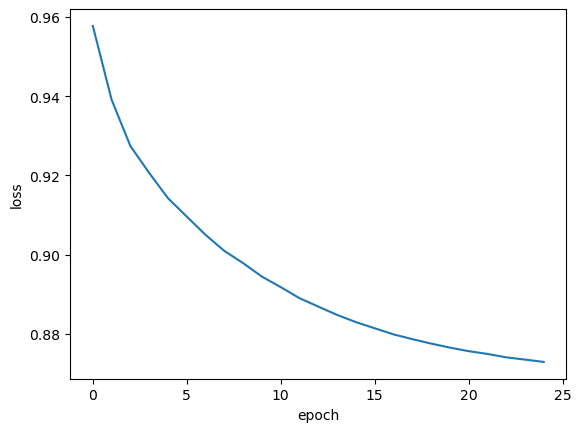

In [14]:
loss = analysis.parse_loss(f'{WORKDIR}/run.log')
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')

### PCA

In [15]:
pc, pca = analysis.run_pca(z)

(INFO) (analysis.py) (19-Apr-23 08:07:12) Explained variance ratio:
(INFO) (analysis.py) (19-Apr-23 08:07:12) [0.4684697  0.41455302 0.05755991 0.02220236 0.01720278 0.00957902
 0.00617308 0.00426013]


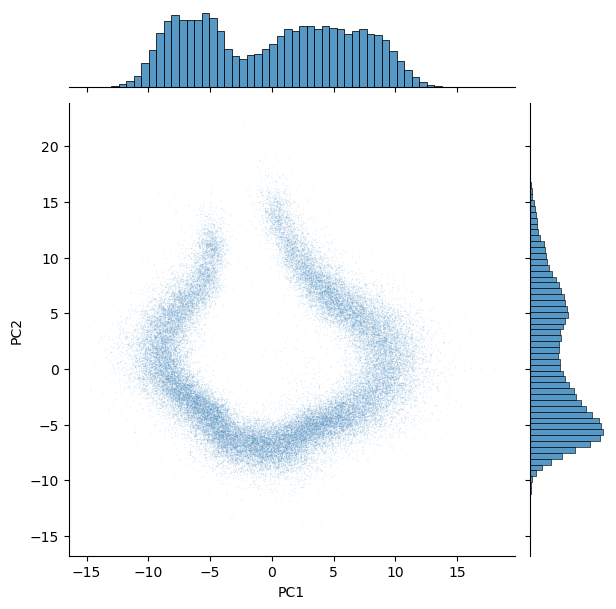

In [16]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

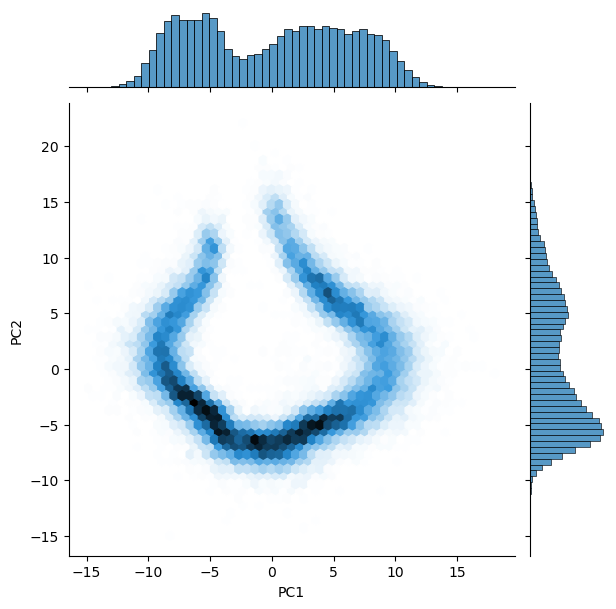

In [17]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

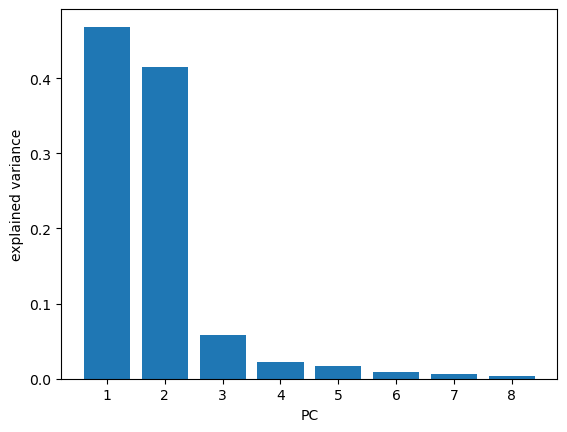

In [18]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### View pose distribution

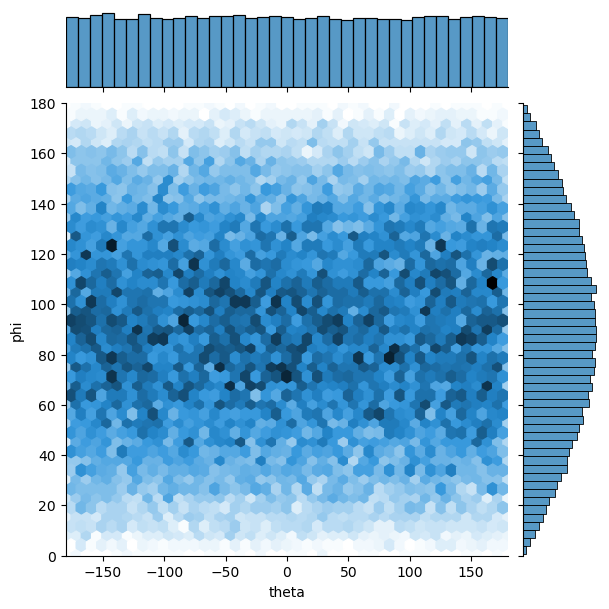

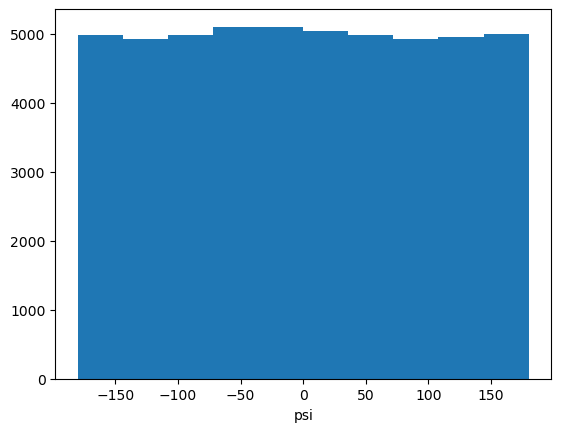

In [19]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

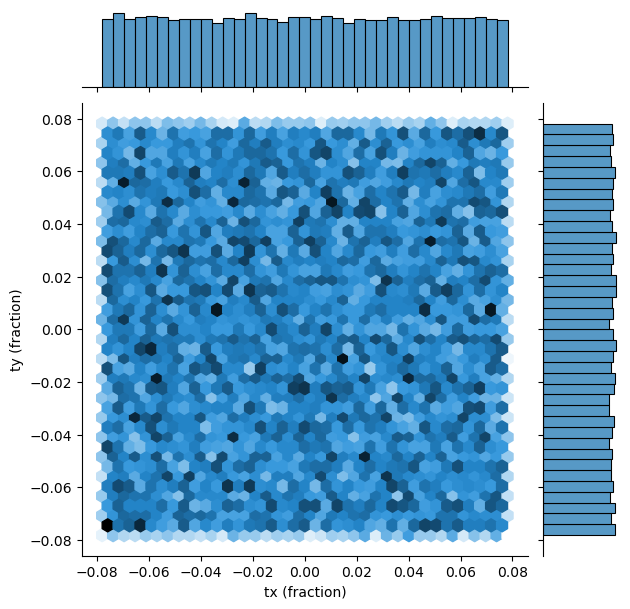

In [20]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### View UMAP

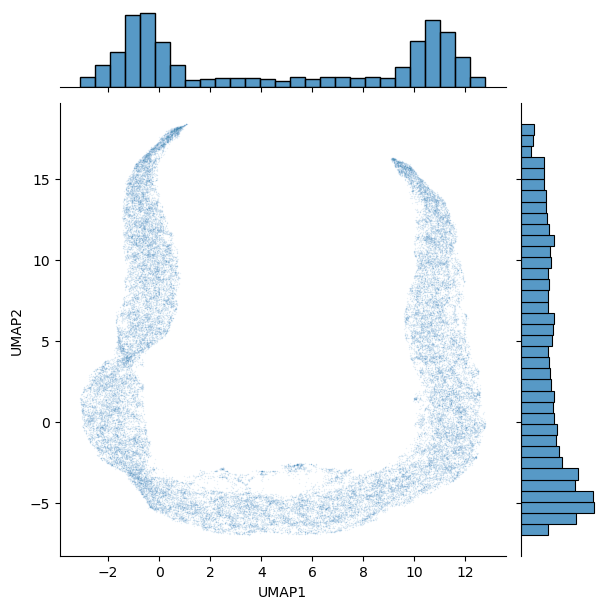

In [21]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

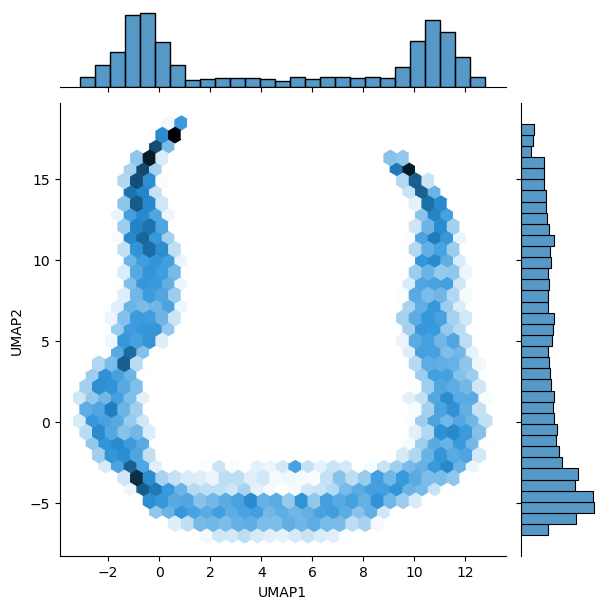

In [22]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

### View K-means clusters

Text(0, 0.5, 'PC2')

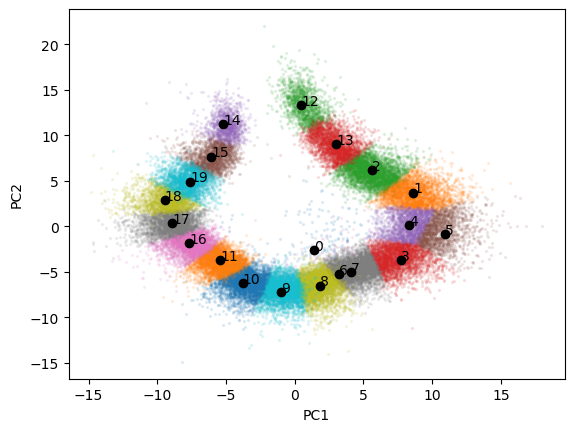

In [23]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

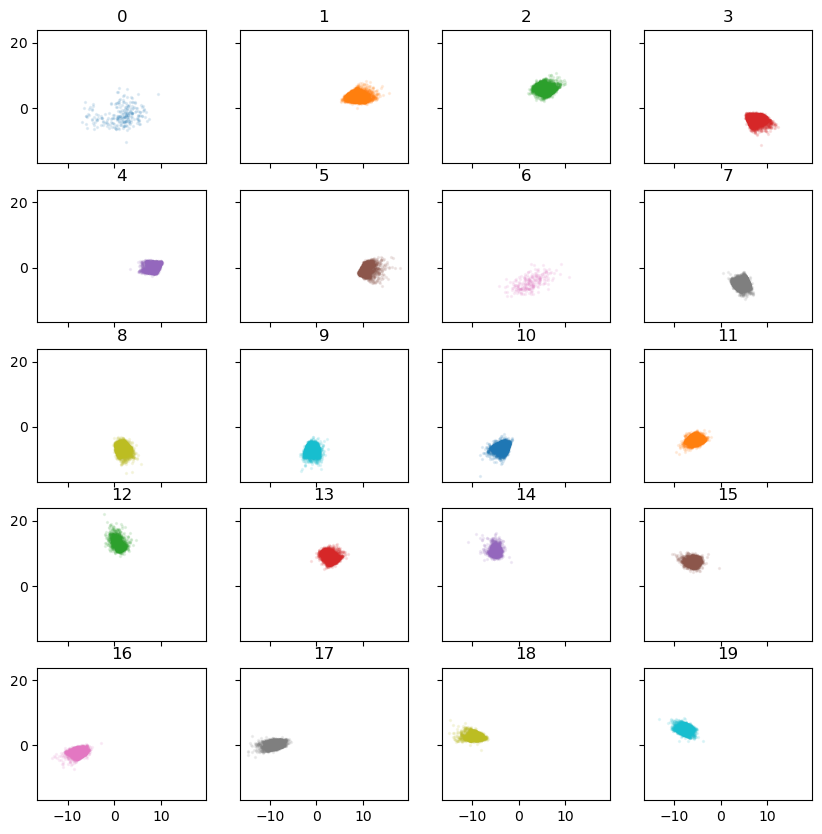

In [24]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

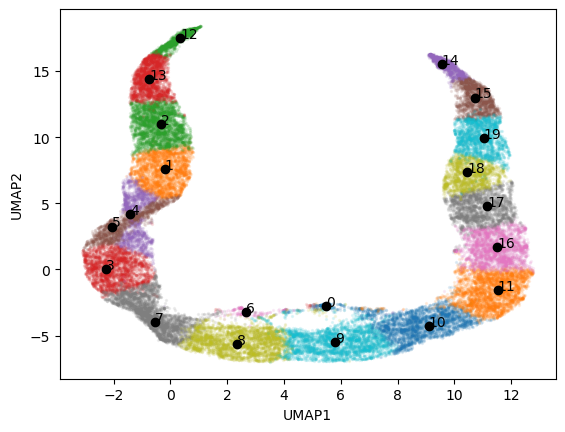

In [25]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

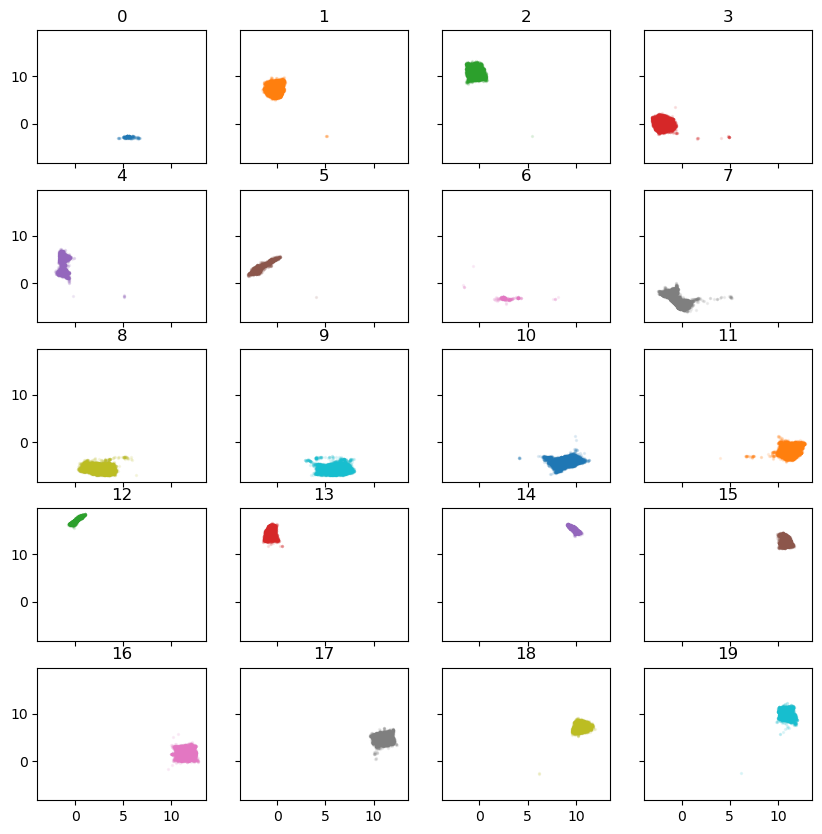

In [26]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

### Load into pandas dataframe

In [27]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8])
df.head()

UMAP1      UMAP2       PC1        PC2       PC3       PC4       PC5  \
0   9.267714  16.220325 -4.732914  12.160830  7.960420  3.553777 -1.176967   
1  10.314787  14.926056 -4.139880   9.065232  5.033923  1.815212 -0.439580   
2  10.269201  14.660033 -4.727506   9.450333  5.193336  0.924270 -0.225563   
3  10.064677  14.688789 -5.007254   9.918421  5.099020  0.761818 -0.352014   
4   9.652749  15.605973 -4.920674  11.103416  5.925055  2.921010  0.365574   

        PC6       PC7       PC8  ...        z3        z4        z5        z6  \
0 -0.861879 -2.509855  0.497548  ... -0.558044 -1.782684 -2.394480  5.748262   
1 -0.507589 -2.035313 -0.885139  ...  0.266839 -0.712881 -2.296971  4.879904   
2 -0.387187 -0.845999 -0.427323  ...  0.237245 -1.159217 -1.727198  5.403545   
3 -0.956396 -0.893599 -0.354950  ...  0.041432 -1.180825 -1.813268  5.820194   
4 -0.525497 -0.984668 -0.911930  ...  0.642155 -0.736499 -2.528691  5.935208   

         z7           df1           df2  dfang  phase  index  
0  0.146379  26795.699219  26795.699219    0.0    0.0      0  
1 -0.305737  16534.980469  16534.980469    0.0    0.0      1  
2 -0.308241  22468.070312  22468.070312    0.0    0.0      2  
3 -0.712957  15173.799805  15173.799805    0.0    0.0      3  
4  1.054079  21441.529297  21441.529297    0.0    0.0      4  

[5 rows x 29 columns]

In [28]:
# Annotated points correspond to kmeans cluster centers
widget, fig = analysis.ipy_plot_interactive_annotate(df,centers_ind)
VBox((widget,fig))

# Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, use the next cell to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [29]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [30]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = np.array(sorted(set(np.arange(len(df))) - set(ind_selected)))

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    0     1     2 ... 49997 49998 49999]
Number of selected points:
50000
Number of unselected points:
0


### Visualize selected subset

Text(0, 0.5, 'PC2 (0.41)')

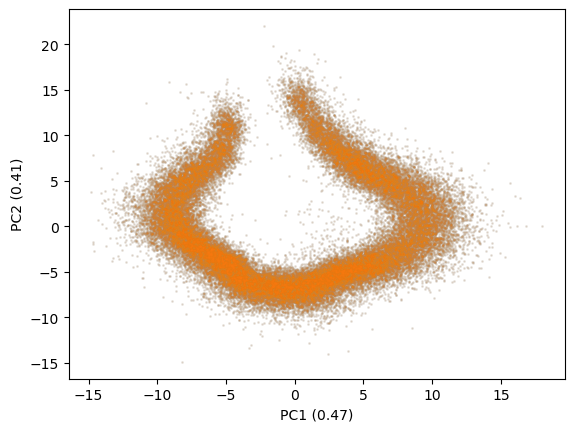

In [31]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

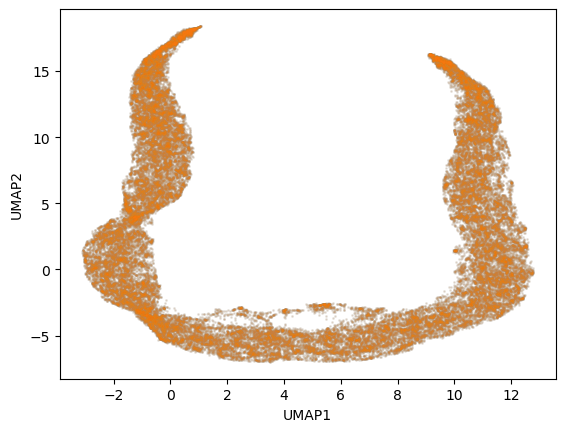

In [32]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [33]:
# Subset of dataframe
df_sub = df.loc[ind_selected]
df_sub_not = df.loc[ind_selected_not]

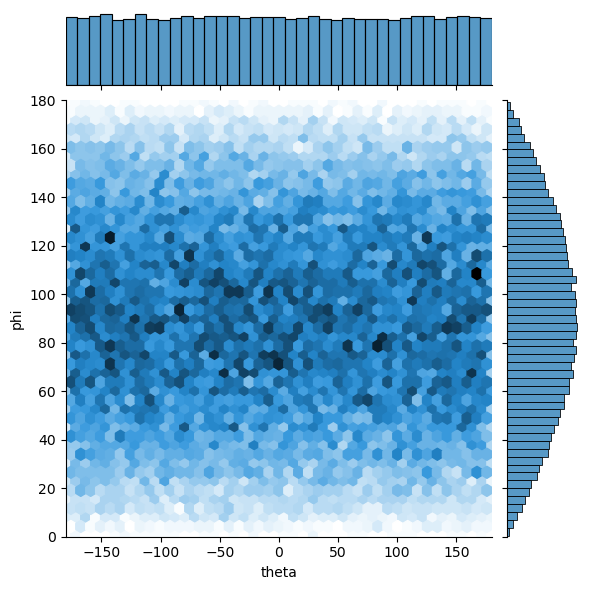

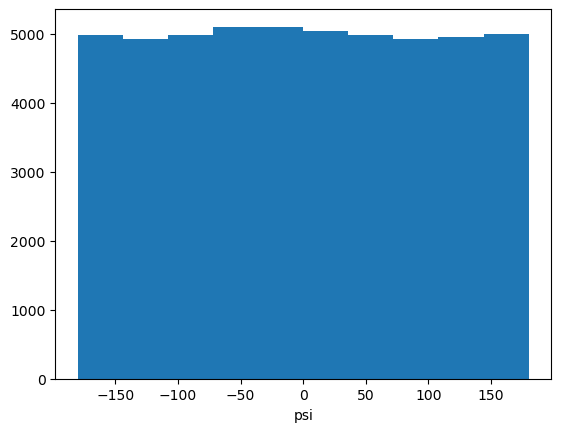

In [34]:
# View pose distribution
analysis.plot_euler(df_sub.theta, df_sub.phi, df_sub.psi)

In [35]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df_sub)
VBox((widget,fig,ind_table))

### Save the index selection

The indices for the selected particles may be saved for use in downstream processing in cryoDRGN or with other tools. Within cryoDRGN, selections are saved as an index array in `.pkl` file format. Then, the selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images. 

Tools are provided in the `utils` subdirectory of the cryoDRGN repo to help convert the index selection to `.star` file format.

**NOTE:** If there are multiple rounds of index filtering performed on the same particle stack (i.e. your results come from a training run that already uses an --ind subselection), the index selection must be converted into the correct indices into the original dataset.

In [ ]:
#SAVE_PATH = f'{WORKDIR}/ind_selected.pkl' # RENAME ME

## IMPORTANT: convert index selection to original particles indices if current results have already been filtered

#if ind_orig is not None:
#    ind_selected_orig = analysis.convert_original_indices(ind_selected, N_orig, ind_orig)
#    utils.save_pkl(ind_selected_orig, SAVE_PATH)

#else:
#    utils.save_pkl(ind_selected, SAVE_PATH)

# View particles

View images at selected points in latent space

In [36]:
particle_ind = ind_selected # or set to custom selection

In [37]:
# choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[33445  2244  6937 14792 20420 23702 47485  3668 29803]


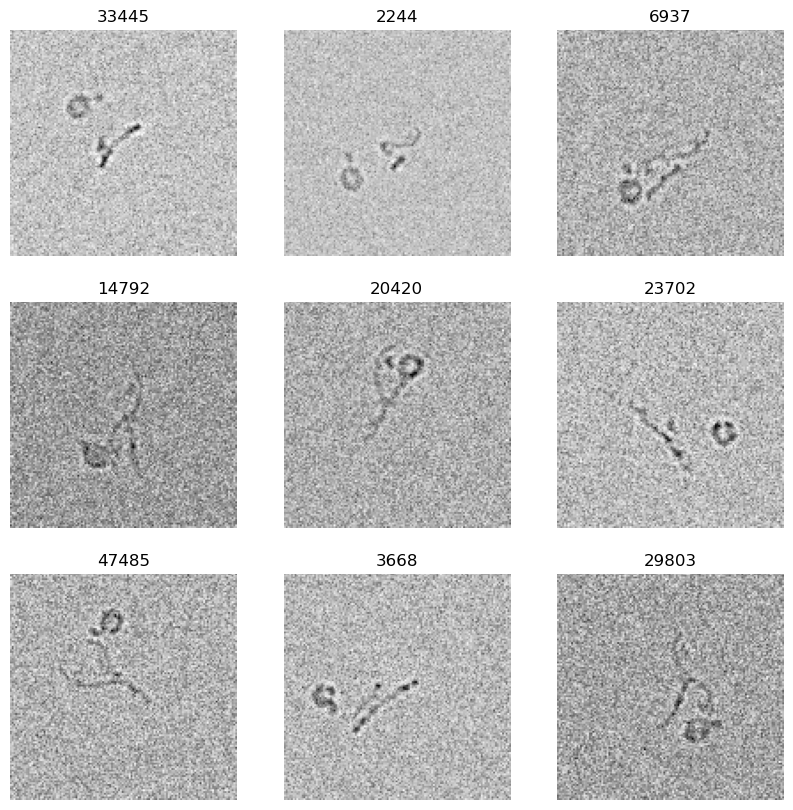

In [38]:
p = [particles[ii].get() for ii in ind_subset9]
analysis.plot_projections(p, ind_subset9)
widget, fig = analysis.ipy_plot_interactive_annotate(df, ind_subset9, opacity=.1)
VBox((widget,fig))

# Generate volumes

Generate volumes at selected points in latent space

In [40]:
vol_ind = [22335] # ADD INDICES HERE
print(vol_ind)

[22335]


In [41]:
widget, fig = analysis.ipy_plot_interactive_annotate(df, vol_ind, opacity=.1)
VBox((widget,fig))

In [42]:
def get_outdir():
    '''Helper function to get a clean directory to save volumes'''
    for i in range(100000):
        outdir = f'reconstruct_{i:06d}'
        if os.path.exists(outdir): continue
        else: break
    return outdir

def generate_volumes(zvalues, outdir, **kwargs):
    '''Helper function to call cryodrgn eval_vol and generate new volumes'''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(f'{WORKDIR}/weights.{EPOCH}.pkl',
                         f'{WORKDIR}/config.pkl',
                         f'{outdir}/zfile.txt',
                         f'{outdir}', **kwargs)
    return FileLinks(f'{outdir}/')

In [43]:
# Get a unique output directory, or define your own
outdir = get_outdir()
print(os.path.abspath(outdir))

/Users/manifect/Desktop/Yaozhigang project/temp_result/01_cryodrgn128-uniform/analyze.24/reconstruct_000000


In [45]:
# Modify any defaults for volume generation -- see `cryodrgn eval_vol -h` for details 
Apix = 1 # Set to volume pixel size
flip = False # Hand flip?
invert = False # Invert contrast?
downsample = None # Set to smaller box size if desired
cuda = None # specify cuda device

generate_volumes(z[vol_ind], outdir, Apix=Apix, flip=flip, downsample=downsample, invert=invert)

(INFO) (eval_vol.py) (19-Apr-23 08:13:25) Use cuda False
(WARNING) (eval_vol.py) (19-Apr-23 08:13:25) WARNING: No GPUs detected
(INFO) (eval_vol.py) (19-Apr-23 08:13:25) Namespace(weights='..//weights.24.pkl', config='..//config.pkl', o='/Users/manifect/Desktop/Yaozhigang project/temp_result/01_cryodrgn128-uniform/analyze.24/reconstruct_000000', device=None, prefix='vol_', verbose=False, z=None, z_start=None, z_end=None, n=10, zfile='reconstruct_000000/zfile.txt', Apix=1.0, flip=False, invert=False, downsample=None, vol_start_index=0, norm=None, D=None, qlayers=None, qdim=None, zdim=None, encode_mode=None, players=None, pdim=None, enc_mask=None, pe_type=None, feat_sigma=None, pe_dim=None, domain=None, l_extent=None, activation='relu')
(INFO) (eval_vol.py) (19-Apr-23 08:13:25) Loaded configuration:
{'dataset_args': {'ctf': '/Users/manifect/Desktop/Yaozhigang '
                         'project/uniform/ctf.pkl',
                  'datadir': None,
                  'do_pose_sgd': False,
 

reconstruct_000000/
  zfile.txt
  vol_000.mrc